# Generalized Advantage Estimation

## Imports

In [1]:
import gym
gym.logger.set_level(40)

import argparse, os
import numpy as np
from timeit import default_timer as timer
from datetime import timedelta
from collections import deque

import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

from utils import save_config, update_linear_schedule, create_directory
from utils.wrappers import make_env_atari
from utils.plot import plot_reward
from utils.hyperparameters import PolicyConfig

from IPython.display import clear_output

from agents.A2C import Model

## Hyperparameters

In [2]:
config = PolicyConfig()
config.algo = 'a2c'
config.env_id = 'BreakoutNoFrameskip-v4'

#preprocessing
config.stack_frames = 4
config.adaptive_repeat = [4]

#Recurrent control
config.recurrent_policy_grad = False
config.gru_size = 512 #also used as outp size of first fc layer
if config.recurrent_policy_grad:
    model_architecture = 'recurrent/'
else:
    model_architecture = 'feedforward/'

config.USE_GAE = True
config.gae_tau = 0.95

#a2c control
config.num_agents=16
config.rollout=5

#RMSProp params
config.rms_alpha = 0.99
config.rms_eps = 1e-5

#misc agent variables
config.GAMMA=0.99
config.LR=7e-4
config.entropy_loss_weight=0.01
config.value_loss_weight=0.5
config.grad_norm_max=0.5

#recurrency
config.recurrent_policy = False
config.gru_size = 512

#training loop params
config.seed = None
config.inference = False
config.sticky_actions = 0.0
config.print_threshold = 100
config.save_threshold = 1000
config.use_lr_schedule = True
config.render = False

config.MAX_FRAMES=1e7

max_epochs = int(config.MAX_FRAMES / config.num_agents / config.rollout)

## Rollout Storage

In [3]:
def _flatten_helper(T, N, _tensor):
    return _tensor.view(T * N, *_tensor.size()[2:])

class RolloutStorage(object):
    def __init__(self, num_steps, num_processes, obs_shape, action_space, state_size, device, USE_GAE=True, gae_tau=0.95):
        self.observations = torch.zeros(num_steps + 1, num_processes, *obs_shape).to(device)
        self.states = torch.zeros(num_steps + 1, num_processes, state_size).to(device)
        self.rewards = torch.zeros(num_steps, num_processes, 1).to(device)
        self.value_preds = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.returns = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.action_log_probs = torch.zeros(num_steps, num_processes, 1).to(device)
        self.actions = torch.zeros(num_steps, num_processes, 1).to(device, torch.long)
        self.masks = torch.ones(num_steps + 1, num_processes, 1).to(device)

        self.num_steps = num_steps
        self.step = 0
        self.gae = USE_GAE
        self.gae_tau = gae_tau

    def insert(self, current_obs, state, action, action_log_prob, value_pred, reward, mask):
        self.observations[self.step + 1].copy_(current_obs)
        self.states[self.step + 1].copy_(state)
        self.actions[self.step].copy_(action)
        self.action_log_probs[self.step].copy_(action_log_prob)
        self.value_preds[self.step].copy_(value_pred)
        self.rewards[self.step].copy_(reward)
        self.masks[self.step + 1].copy_(mask)

        self.step = (self.step + 1) % self.num_steps

    def after_update(self):
        self.observations[0].copy_(self.observations[-1])
        self.states[0].copy_(self.states[-1])
        self.masks[0].copy_(self.masks[-1])

    def compute_returns(self, next_value, gamma):
        if self.gae:
            self.value_preds[-1] = next_value
            gae = 0
            for step in reversed(range(self.rewards.size(0))):
                delta = self.rewards[step] + gamma * self.value_preds[step + 1] * self.masks[step + 1] - self.value_preds[step]
                gae = delta + gamma * self.gae_tau * self.masks[step + 1] * gae
                self.returns[step] = gae + self.value_preds[step]
        else:
            self.returns[-1] = next_value
            for step in reversed(range(self.rewards.size(0))):
                self.returns[step] = self.returns[step + 1] * \
                    gamma * self.masks[step + 1] + self.rewards[step]

## Training Loop

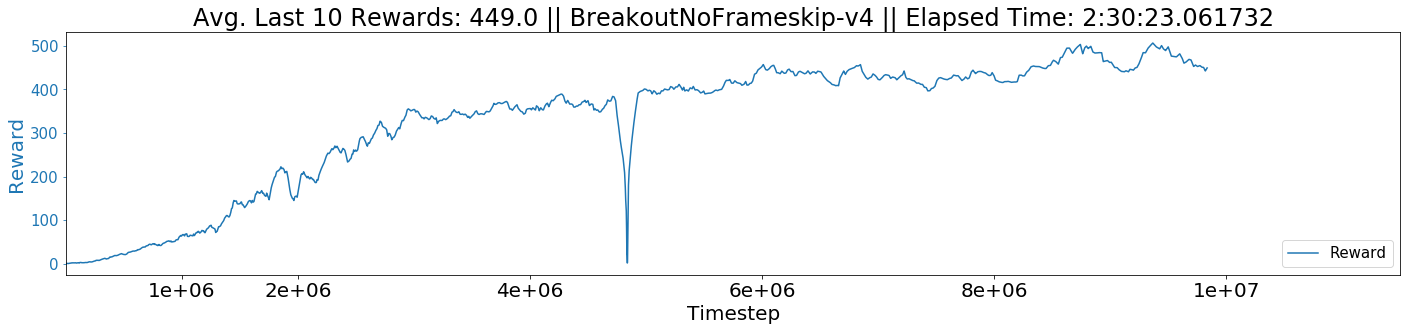

In [4]:
def train(config):
    #make/clear directories for logging
    base_dir = os.path.join('./results/', config.algo, model_architecture, config.env_id)
    log_dir = os.path.join(base_dir, 'logs/')   
    model_dir = os.path.join(base_dir, 'saved_model/')
    tb_dir = os.path.join(base_dir, 'runs/')
    create_directory(base_dir)
    create_directory(log_dir)
    create_directory(model_dir)
    create_directory(tb_dir)

    #Tensorboard writer
    writer = SummaryWriter(log_dir=os.path.join(base_dir, 'runs'))
    
    #save configuration for later reference
    save_config(config, base_dir)

    #set seeds
    seed = np.random.randint(0, int(1e6)) if config.seed is None else config.seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    envs = [make_env_atari(config.env_id, seed, i, log_dir, stack_frames=config.stack_frames, adaptive_repeat=config.adaptive_repeat, sticky_actions=config.sticky_actions, clip_rewards=True) for i in range(config.num_agents)]
    envs = SubprocVecEnv(envs)

    model = Model(env=envs, config=config, log_dir=base_dir, static_policy=config.inference, tb_writer=writer)

    obs = envs.reset()
    
    obs = torch.from_numpy(obs.astype(np.float32)).to(config.device)

    model.config.rollouts.observations[0].copy_(obs)
    
    episode_rewards = np.zeros(config.num_agents, dtype=np.float)
    final_rewards = np.zeros(config.num_agents, dtype=np.float)
    last_100_rewards = deque(maxlen=100)

    start = timer()
    
    last_log = timer()
    last_reward_logged = 0
    
    for epoch in range(1, max_epochs+1):
        if config.use_lr_schedule:
            update_linear_schedule(model.optimizer, epoch-1, max_epochs, config.LR)

        for step in range(config.rollout):
            with torch.no_grad():
                values, actions, action_log_prob, states = model.get_action(
                                                            model.config.rollouts.observations[step],
                                                            model.config.rollouts.states[step],
                                                            model.config.rollouts.masks[step])
            
            cpu_actions = actions.view(-1).cpu().numpy()
    
            obs, reward, done, info = envs.step(cpu_actions)

            obs = torch.from_numpy(obs.astype(np.float32)).to(config.device)

            #agent rewards
            episode_rewards += reward
            masks = 1. - done.astype(np.float32)
            final_rewards *= masks
            final_rewards += (1. - masks) * episode_rewards
            episode_rewards *= masks

            for index, inf in enumerate(info):
                current_tstep = (epoch-1)*config.rollout*config.num_agents \
                    +step*config.num_agents+index
                if 'episode' in inf.keys():
                    last_100_rewards.append(inf['episode']['r'])
                    writer.add_scalar('Performance/Environment Reward', inf['episode']['r'], current_tstep)
                    writer.add_scalar('Performance/Episode Length', inf['episode']['l'], current_tstep)

                if done[index]:
                    #write reward on completion
                    writer.add_scalar('Performance/Agent Reward', final_rewards[index], \
                        current_tstep)

            rewards = torch.from_numpy(reward.astype(
                np.float32)).view(-1, 1).to(config.device)
            masks = torch.from_numpy(masks).to(config.device).view(-1, 1)

            obs *= masks.view(-1, 1, 1, 1)

            model.config.rollouts.insert(obs, states, actions.view(-1, 1), 
                                         action_log_prob, values, rewards, 
                                         masks)
            
        with torch.no_grad():
            next_value = model.get_values(model.config.rollouts.observations[-1],
                                model.config.rollouts.states[-1],
                                model.config.rollouts.masks[-1])
            
        value_loss, action_loss, dist_entropy, dynamics_loss = model.update(model.config.rollouts, next_value, 
                                                                            epoch*config.rollout*config.num_agents)
        
        model.config.rollouts.after_update()

        if epoch % config.save_threshold == 0:
            model.save_w()

        if epoch % config.print_threshold == 0:
            #print
            end = timer()
            
            clear_output(True)
            plot_reward(log_dir, config.env_id, config.MAX_FRAMES, bin_size=10, smooth=1, \
                time=timedelta(seconds=end-start), save_filename='results.png', ipynb=True)
    
    clear_output(True)
    plot_reward(log_dir, config.env_id, config.MAX_FRAMES, bin_size=10, smooth=1, \
        time=timedelta(seconds=end-start), save_filename='results.png', ipynb=True)

    model.save_w()
    envs.close()
            
    
if __name__=='__main__':
    train(config)